In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [ ]:
# Load datase
data = pd.read_csv('./DATA/Medical_insurance.csv')

In [ ]:
# Preprocessing
data['smoker'] = data['smoker'].map({'yes': 1, 'no': 0})
data['sex'] = data['sex'].map({'male': 1, 'female': 0})
data = pd.get_dummies(data, columns=['region'], drop_first=True)

In [ ]:
# Split dataset into features and target
X = data.drop(columns='charges').values
y = data['charges'].values

In [ ]:
# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
# Simulate splitting data across clients
num_clients = 4
client_data = []
data_split = np.array_split(range(len(X)), num_clients)
for split in data_split:
    client_data.append((X[split], y[split]))

In [ ]:
# Define the global model for global training
global_training_model = SGDRegressor(max_iter=1000, tol=1e-3, eta0=0.01, learning_rate='constant')

# Global training
global_training_model.fit(X, y)
global_training_loss = mean_squared_error(y, global_training_model.predict(X))

In [ ]:
# Federated training process
global_weights = np.zeros(X.shape[1])
global_bias = 0
num_rounds = 10
learning_rate = 0.01

federated_losses = []
local_losses = []

for round_num in range(num_rounds):
    print(f"Round {round_num + 1}/{num_rounds}")

    # Local training on each client
    client_weights = []
    client_biases = []
    client_losses = []

    for X_client, y_client in client_data:
        # Local model initialization
        local_model = SGDRegressor(max_iter=1, tol=None, eta0=learning_rate, learning_rate='constant')
        local_model.coef_ = global_weights.copy()
        local_model.intercept_ = np.array([global_bias])

        # Train on client data
        local_model.partial_fit(X_client, y_client)

        # Collect local weights and biases
        client_weights.append(local_model.coef_)
        client_biases.append(local_model.intercept_)

        # Calculate local loss
        predictions = local_model.predict(X_client)
        loss = mean_squared_error(y_client, predictions)
        client_losses.append(loss)

    # Aggregate weights and biases (Federated Averaging)
    global_weights = np.mean(client_weights, axis=0)
    global_bias = np.mean(client_biases)

    # Track average federated loss
    avg_loss = np.mean(client_losses)
    federated_losses.append(avg_loss)
    print(f"Average Loss: {avg_loss:.4f}")


Round 1/10
Average Loss: 37917776.5956
Round 2/10
Average Loss: 37849298.5445
Round 3/10
Average Loss: 37817755.9573
Round 4/10
Average Loss: 37690340.4117
Round 5/10
Average Loss: 37790874.6307
Round 6/10
Average Loss: 38223085.8320
Round 7/10
Average Loss: 38121574.7870
Round 8/10
Average Loss: 37800543.9820
Round 9/10
Average Loss: 38440958.0721
Round 10/10
Average Loss: 38258167.6814


In [ ]:
# Evaluate the federated global model
federated_model = SGDRegressor()
federated_model.coef_ = global_weights
federated_model.intercept_ = np.array([global_bias])
federated_final_loss = mean_squared_error(y, federated_model.predict(X))

In [ ]:
# Local training loss tracking
for X_client, y_client in client_data:
    local_model = SGDRegressor(max_iter=1000, tol=1e-3, eta0=learning_rate, learning_rate='constant')
    local_model.fit(X_client, y_client)
    local_loss = mean_squared_error(y_client, local_model.predict(X_client))
    local_losses.append(local_loss)

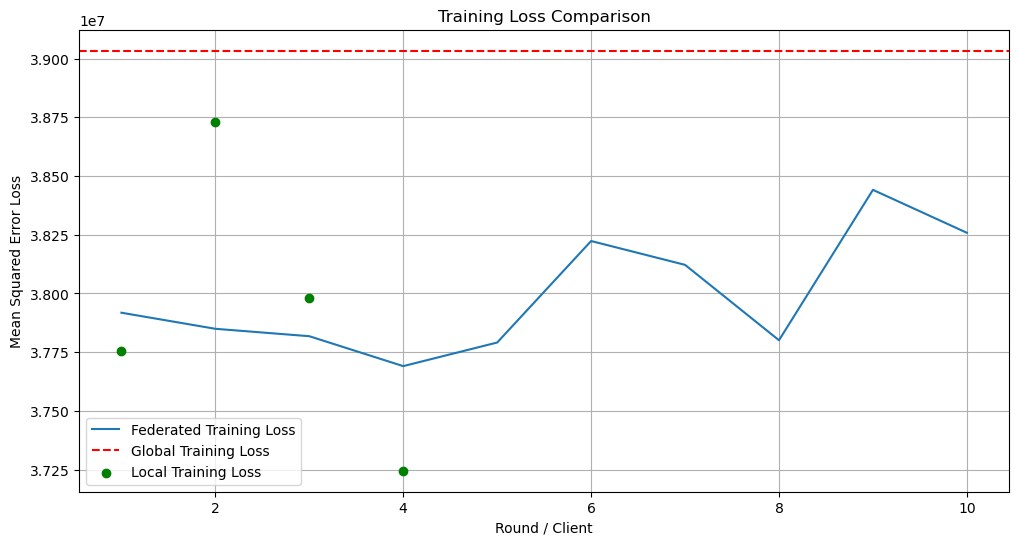

In [ ]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_rounds + 1), federated_losses, label="Federated Training Loss")
plt.axhline(y=global_training_loss, color='r', linestyle='--', label="Global Training Loss")
plt.scatter(range(1, num_clients + 1), local_losses, color='g', label="Local Training Loss", zorder=5)
plt.title("Training Loss Comparison")
plt.xlabel("Round / Client")
plt.ylabel("Mean Squared Error Loss")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:

# Print final results
print(f"\nFinal Global Training Loss: {global_training_loss:.4f}")
print(f"Final Federated Training Loss: {federated_final_loss:.4f}")
print(f"Average Local Training Loss: {np.mean(local_losses):.4f}")



Final Global Training Loss: 39033414.2500
Final Federated Training Loss: 37100136.6549
Average Local Training Loss: 37928511.9284
